In [33]:
# Use with NHL_Model_Data_Transform_v5.py
import pandas as pd
import numpy as np
import seaborn as sns
import os

import matplotlib.pyplot as plt

In [34]:
df = pd.read_csv(r"C:\Users\zchodaniecky\OneDrive - Franklin Templeton\Documents\Python\NHL_data\NHL_Data_Transformed.csv")
#df = pd.read_csv(r"C:\Users\zanec\OneDrive\Documents\Python\NHL_data\NHL_Data_Transformed_PCA - Test v1.csv")

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4261 entries, 0 to 4260
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   team_Home                  4261 non-null   object 
 1   gameId                     4261 non-null   int64  
 2   home_or_away_Home          4261 non-null   object 
 3   win_or_lose_Home           4261 non-null   int64  
 4   seasonPointsPerGame_Home   4261 non-null   float64
 5   goalDiffAvg_Home           4261 non-null   float64
 6   hitsDiffAvg_Home           4261 non-null   float64
 7   pointsFromGameAvg_Home     4261 non-null   float64
 8   fenwickPercentageAvg_Home  4261 non-null   float64
 9   reboundsForAvg_Home        4261 non-null   float64
 10  team_Away                  4261 non-null   object 
 11  home_or_away_Away          4261 non-null   object 
 12  win_or_lose_Away           4261 non-null   int64  
 13  seasonPointsPerGame_Away   4261 non-null   float

In [36]:
df = df.drop(columns=['team_Home','team_Away','gameId','home_or_away_Home','home_or_away_Away','win_or_lose_Away'])

In [37]:
# df.hist(bins=50, figsize=(20,15))
# plt.show()

In [38]:
# Heatmap to visualize correlations
corr_matrix = df.corr(numeric_only=True)
# sns.heatmap(corr_matrix, cmap="PiYG")

In [39]:
corr_matrix['win_or_lose_Home'].sort_values(ascending=False)

win_or_lose_Home             1.000000
seasonPointsPerGame_Home     0.308311
fenwickPercentageAvg_Home    0.139362
goalDiffAvg_Home             0.076082
pointsFromGameAvg_Home       0.072489
hitsDiffAvg_Away             0.057848
reboundsForAvg_Home          0.041695
penaltiesAgainstTotal        0.021285
penaltiesForTotal           -0.016758
hitsDiffAvg_Home            -0.022717
reboundsForAvg_Away         -0.048594
goalDiffAvg_Away            -0.085647
pointsFromGameAvg_Away      -0.091419
fenwickPercentageAvg_Away   -0.143173
seasonPointsPerGame_Away    -0.302446
Name: win_or_lose_Home, dtype: float64

In [40]:
# Visualize distributions of attributes
# from pandas.plotting import scatter_matrix

# attributes = ['fenwickPercentageAvg_Home','goalDiffAvg_Home','seasonPointsPerGame_Home','seasonPointsPerGame_Away']
# scatter_matrix(df[attributes], figsize=(12,8));

In [41]:
# These are tentative just to test

df_Final = df
# df_Final = df.drop(columns=['corsiPercentageAvg_Away','penaltiesAgainstTotal','shotsOnGoalDiffAvg_Away'])

In [42]:
from sklearn.model_selection import train_test_split

# Split into 80% training data and 20% testing data
train_set, test_set = train_test_split(df_Final, test_size=0.2, random_state=42)

nhl = train_set.drop('win_or_lose_Home', axis=1)
nhl_labels = train_set['win_or_lose_Home'].copy()

df_Final = df_Final.drop('win_or_lose_Home', axis=1)

In [43]:
# Pipeline constructor used to run transformation steps in order
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

nhl_prepared = num_pipeline.fit_transform(nhl)

In [44]:
# Fine Tune the hyperparameters of RandomForest model
# from sklearn.model_selection import GridSearchCV

# param_grid = [{'n_estimators' : [100,500,1000], 'max_leaf_nodes': [10,16,25,50], 'n_jobs' : [-1]},
#               {'bootstrap': [False], 'n_estimators' : [100,500,1000], 'max_leaf_nodes': [10,16,25,50], 'n_jobs' : [-1]},]

# rnd_clf_test = RandomForestClassifier()

# grid_search = GridSearchCV(rnd_clf_test, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# grid_search.fit(nhl_prepared,nhl_labels)

# grid_search.best_params_

In [45]:
# cvres = grid_search.cv_results_
# results = []
# for mean_scores, params in zip(cvres["mean_test_score"], cvres["params"]):
#     results.append([np.sqrt(-mean_scores),params])

# results2 = sorted(results, key=lambda x: x[0])
# print(*results2, sep = '\n')

In [49]:
# Try using a Random Forest
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, n_jobs=-1, random_state=69)

rnd_clf.fit(nhl, nhl_labels)

RandomForestClassifier(max_leaf_nodes=50, n_estimators=500, n_jobs=-1,
                       random_state=69)

In [58]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(rnd_clf, nhl_prepared, nhl_labels, cv=5)

from sklearn.metrics import confusion_matrix

confusion_matrix(nhl_labels, y_train_pred)

array([[ 996,  605],
       [ 518, 1289]], dtype=int64)

In [59]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('When claiming is a win, correct % is ', precision_score(nhl_labels, y_train_pred))

print('Detected % of wins' ,recall_score(nhl_labels, y_train_pred))

print('F1 score is ', f1_score(nhl_labels, y_train_pred))

print('Accuracy score is ', accuracy_score(nhl_labels, y_train_pred))

When claiming is a win, correct % is  0.6805702217529039
Detected % of wins 0.7133370226895407
F1 score is  0.6965684950013511
Accuracy score is  0.670481220657277


In [52]:
# Use this to see importance of each feature in the Random Forest
# Take colmumn names from Final DataFrame, need to skip the label though

for name, score in zip(nhl.columns.values,rnd_clf.feature_importances_):
    print(name,round(score*100,2))

seasonPointsPerGame_Home 24.13
goalDiffAvg_Home 4.09
hitsDiffAvg_Home 3.83
pointsFromGameAvg_Home 3.99
fenwickPercentageAvg_Home 5.1
reboundsForAvg_Home 3.6
seasonPointsPerGame_Away 26.27
goalDiffAvg_Away 4.31
hitsDiffAvg_Away 4.1
pointsFromGameAvg_Away 4.25
fenwickPercentageAvg_Away 5.75
reboundsForAvg_Away 3.52
penaltiesForTotal 3.4
penaltiesAgainstTotal 3.65


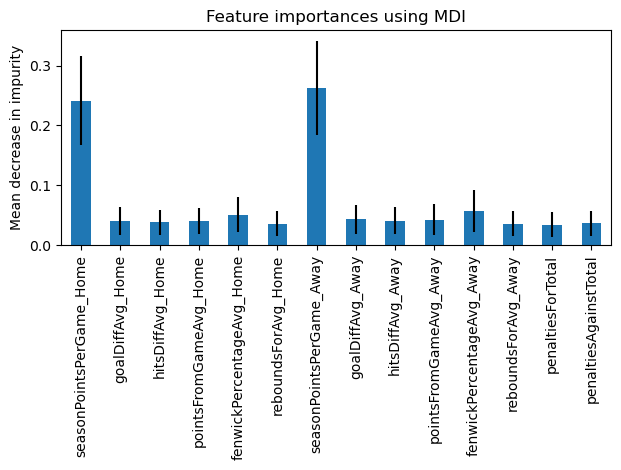

In [53]:
import pandas as pd

forest_importances = pd.Series(rnd_clf.feature_importances_, index=nhl.columns.values)
std = np.std([tree.feature_importances_ for tree in rnd_clf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [54]:
# # High Cardinality (although not the case here) can caues the built in feature_importance to be innacurate
# # This method takes longer but is more accurate in those situations

# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rnd_clf, nhl_prepared_PCA, nhl_labels, n_repeats=10, random_state=42, n_jobs=2
# )

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

In [55]:
df_Predict = pd.read_csv(r"C:\Users\zchodaniecky\OneDrive - Franklin Templeton\Documents\Python\NHL_data\NHL_Data_Predict.csv")
#df_Predict = pd.read_csv(r"C:\Users\zanec\OneDrive\Documents\Python\NHL_data\NHL_Data_Predict.csv")

In [56]:
nhl_Predict = df_Predict.iloc[:,2:]


np.array((df_Predict.iloc[:,1].values,rnd_clf.predict(nhl_Predict))).T

C:\Users\zchodaniecky\Anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


array([['WSH', 1],
       ['TBL', 1],
       ['LAK', 1],
       ['DET', 1],
       ['PIT', 0],
       ['NJD', 0],
       ['NYR', 1],
       ['EDM', 1]], dtype=object)

array(['seasonPointsPerGame_Home', 'goalDiffAvg_Home', 'hitsDiffAvg_Home',
       'pointsFromGameAvg_Home', 'fenwickPercentageAvg_Home',
       'reboundsForAvg_Home', 'seasonPointsPerGame_Away',
       'goalDiffAvg_Away', 'hitsDiffAvg_Away', 'pointsFromGameAvg_Away',
       'fenwickPercentageAvg_Away', 'reboundsForAvg_Away',
       'penaltiesForTotal', 'penaltiesAgainstTotal'], dtype=object)